In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.models import resnet50
from transformers import ViTModel, ViTConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import os
import time
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
import plotly.express as px
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'knee-osteoarthritis-dataset-with-severity' dataset.
Path to dataset files: /kaggle/input/knee-osteoarthritis-dataset-with-severity


In [3]:
# train_dir='/root/.cache/kagglehub/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/versions/1/train'
# val_dir='/root/.cache/kagglehub/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/versions/1/val'
# test_dir='/root/.cache/kagglehub/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/versions/1/test'

train_dir = f'{path}/train'
val_dir = f'{path}/val'
test_dir = f'{path}/test'

## Data Preprocessing

In [4]:

# 2. Define Transforms
# ImageNet normalization stats (standard for pre-trained CNNs and ViTs)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transforms for Training (includes Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to fixed size (for CNN and ViT)
    transforms.Grayscale(num_output_channels=3), # Ensure 3 channels (R=G=B) for pre-trained models
    transforms.RandomHorizontalFlip(p=0.5),      # Augmentation: Flip left/right (valid for X-rays)
    transforms.RandomRotation(degrees=10),       # Augmentation: Slight rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Transforms for Validation/Test (No Augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 3. Load Data using ImageFolder
# This automatically assigns labels based on folder names (0, 1, 2, 3, 4)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

# Count the number of each label
labels = [label for _, label in train_dataset.imgs]
counts = Counter(labels)
print(counts)

# 4. Create DataLoaders
batch_size = 32 # Adjust based on your GPU memory (ViT consumes more memory)

total = sum(counts.values())

# Weight = total / (num_classes * class_count)  | For each class
num_classes = len(counts)
class_weights = [total / (num_classes * counts[i]) for i in range(num_classes)]
print(f"Class Weights: {class_weights}")
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Verification
print(f"Classes found: {train_dataset.classes}") # Should be ['0', '1', '2', '3', '4']
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}") # Should be [32, 3, 224, 224]

Counter({0: 2286, 2: 1516, 1: 1046, 3: 757, 4: 173})
Class Weights: [0.5055118110236221, 1.1047801147227534, 0.7622691292875989, 1.5265521796565389, 6.679768786127168]
Classes found: ['0', '1', '2', '3', '4']
Batch shape: torch.Size([32, 3, 224, 224])


## Define Model Architecture

In [5]:
from torchvision.models import resnet50, ResNet50_Weights

# Load pretrained CNN: ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Replace the final classification layer to the 5 classes
model.fc = nn.Linear(model.fc.in_features, 5)  # 5 classes: grade 0-4
model = model.to(device)


# Unfreeze all layers
for p in model.parameters():
    p.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


## Instantiate Model, Optimizer, and Loss Function

In [6]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.07)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3)

## Train Model

Tasks:
- Train data using the train_dataset and evaluate model performance using train_dataset and val_dataset tune hyperparameters
- Store and measure both accuracy and loss
- Choose model with best performance on val_dataset

In [7]:
num_epochs = 25
patience = 8
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
f1_score_list = []

best_val_loss = np.inf
epochs_no_improve = 0
best_f1 = 0

for epoch in range(num_epochs):
  # Training mode
  model.train()
  running_loss = 0
  correct_train = 0
  total_train = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Compute training accuracy
    _, preds = torch.max(outputs, 1)
    correct_train += (preds == labels).sum().item()
    total_train += labels.size(0)

  train_loss = running_loss / len(train_loader)
  train_accuracy = correct_train / total_train

  train_loss_list.append(train_loss)
  train_acc_list.append(train_accuracy)

  # Evaluation mode
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  all_labels = []
  all_preds = []

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())

  val_loss = val_loss / len(val_loader)
  val_accuracy = correct / total
  val_f1 = f1_score(all_labels, all_preds, average='macro')

  val_loss_list.append(val_loss)
  val_acc_list.append(val_accuracy)
  f1_score_list.append(val_f1)

  scheduler.step(val_loss)

  if val_f1 > best_f1:
    best_f1 = val_f1
    epochs_no_improve = 0
    print("New best model")
    torch.save(model.state_dict(), 'best_model1.pt')
  else:
    epochs_no_improve += 1
    print(f"EarlyStopping counter: {epochs_no_improve} out of {patience}")
    if epochs_no_improve >= patience:
      print(f"Early stopping triggered after {epoch+1} epochs.")
      break

  print(f"Epoch {epoch+1}/{num_epochs} | "
    f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
    f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
    f"F1 Score: {val_f1:.4f} | Best F1: {best_f1:.4f}")

New best model
Epoch 1/25 | Train Loss: 1.5266 | Train Acc: 0.3685 | Val Loss: 1.5206 | Val Acc: 0.5230 | F1 Score: 0.5667 | Best F1: 0.5667
EarlyStopping counter: 1 out of 8
Epoch 2/25 | Train Loss: 1.2453 | Train Acc: 0.5511 | Val Loss: 1.4824 | Val Acc: 0.5363 | F1 Score: 0.5644 | Best F1: 0.5667
New best model
Epoch 3/25 | Train Loss: 1.1587 | Train Acc: 0.5995 | Val Loss: 1.3998 | Val Acc: 0.6029 | F1 Score: 0.5785 | Best F1: 0.5785
New best model
Epoch 4/25 | Train Loss: 1.1329 | Train Acc: 0.6168 | Val Loss: 1.4141 | Val Acc: 0.6186 | F1 Score: 0.6168 | Best F1: 0.6168
New best model
Epoch 5/25 | Train Loss: 1.0793 | Train Acc: 0.6520 | Val Loss: 1.3748 | Val Acc: 0.6102 | F1 Score: 0.6630 | Best F1: 0.6630
EarlyStopping counter: 1 out of 8
Epoch 6/25 | Train Loss: 1.0751 | Train Acc: 0.6591 | Val Loss: 1.4064 | Val Acc: 0.5738 | F1 Score: 0.6361 | Best F1: 0.6630
EarlyStopping counter: 2 out of 8
Epoch 7/25 | Train Loss: 1.0045 | Train Acc: 0.7006 | Val Loss: 1.3863 | Val Acc: 

In [8]:
model.load_state_dict(torch.load('best_model1.pt', map_location=device))

<All keys matched successfully>

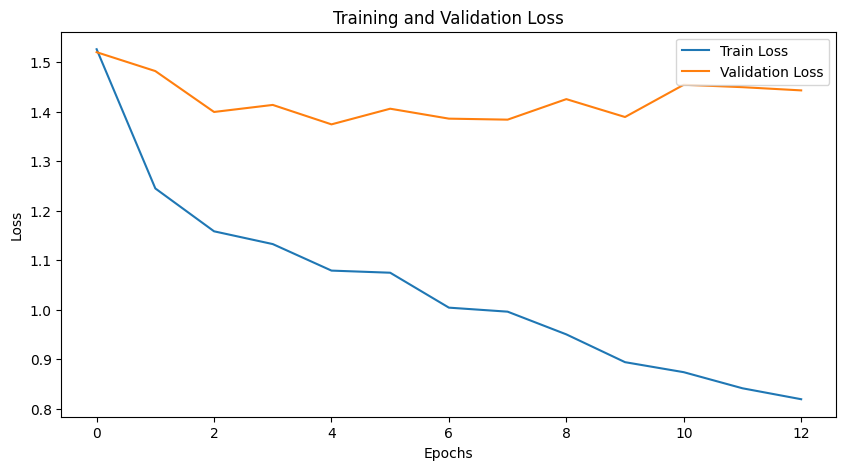

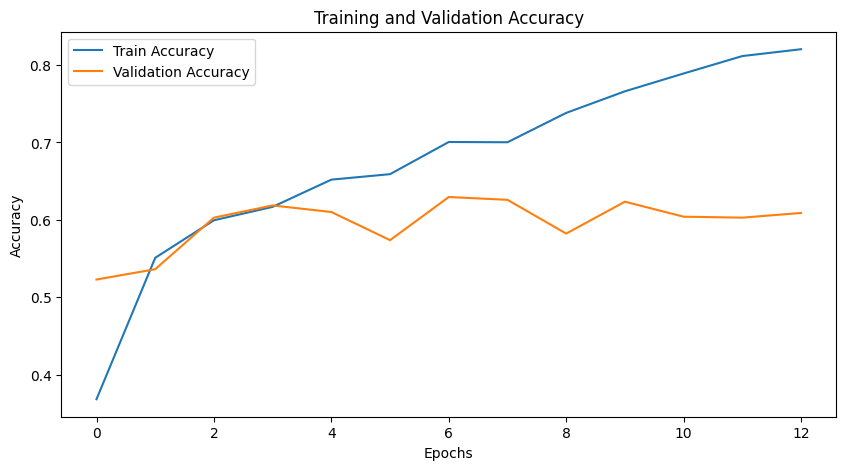

In [9]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate Model on Test Data

Tasks:
- Use trained model and evaluate on test_dataset
- Measure both accuracy and loss

In [10]:
model.eval()
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Loss: 1.3569
Final Test Accuracy: 0.6262


## Compute Accuracy, Precision, Recall, F1 Score, and Confusion Matrix

In [11]:
def evaluate_model(model, data_loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm

In [12]:
val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(model, val_loader, device)

print("Validation Results")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print("Confusion Matrix:\n", val_cm)

test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)

print("Test Results")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print("Confusion Matrix:\n", test_cm)


Validation Results
Accuracy: 0.6101694915254238
Precision: 0.6894374874070438
Recall: 0.6564966458025661
F1 Score: 0.6630185443052504
Confusion Matrix:
 [[216  92  18   2   0]
 [ 55  74  19   5   0]
 [ 23  63 103  23   0]
 [  2   4  11  89   0]
 [  0   0   0   5  22]]
Test Results
Accuracy: 0.626207729468599
Precision: 0.6640296259980389
Recall: 0.6450567997121712
F1 Score: 0.644186341850492
Confusion Matrix:
 [[467 156  15   0   1]
 [ 97 137  54   8   0]
 [ 41 134 209  63   0]
 [  0  13  17 187   6]
 [  0   0   0  14  37]]


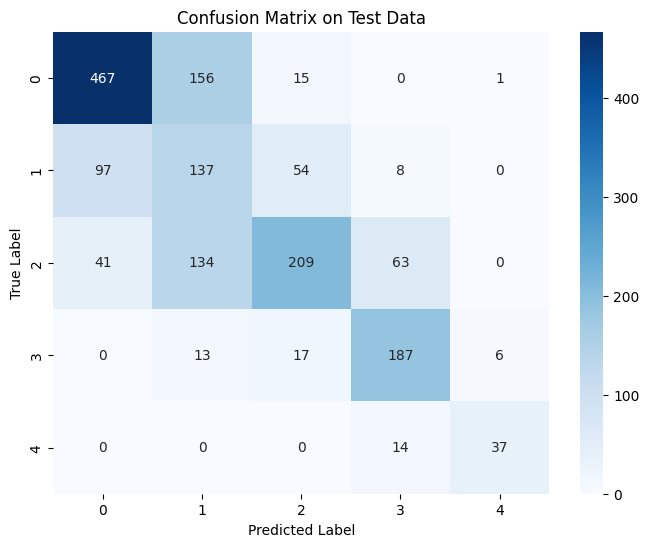

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()

# CNN Model 2

New best model
Epoch 1/25 | Train Loss: 1.5674 | Train Acc: 0.3276 | Val Loss: 1.5704 | Val Acc: 0.5061 | F1 Score: 0.4520 | Best F1: 0.4520
New best model
Epoch 2/25 | Train Loss: 1.2703 | Train Acc: 0.5308 | Val Loss: 1.5241 | Val Acc: 0.5508 | F1 Score: 0.5391 | Best F1: 0.5391
New best model
Epoch 3/25 | Train Loss: 1.2085 | Train Acc: 0.5715 | Val Loss: 1.4983 | Val Acc: 0.5642 | F1 Score: 0.5816 | Best F1: 0.5816
EarlyStopping counter: 1 out of 8
Epoch 4/25 | Train Loss: 1.1707 | Train Acc: 0.5981 | Val Loss: 1.4922 | Val Acc: 0.5521 | F1 Score: 0.5586 | Best F1: 0.5816
New best model
Epoch 5/25 | Train Loss: 1.1246 | Train Acc: 0.6198 | Val Loss: 1.4945 | Val Acc: 0.5278 | F1 Score: 0.5869 | Best F1: 0.5869
New best model
Epoch 6/25 | Train Loss: 1.0984 | Train Acc: 0.6350 | Val Loss: 1.4233 | Val Acc: 0.5969 | F1 Score: 0.6282 | Best F1: 0.6282
EarlyStopping counter: 1 out of 8
Epoch 7/25 | Train Loss: 1.0712 | Train Acc: 0.6554 | Val Loss: 1.4581 | Val Acc: 0.5811 | F1 Score: 

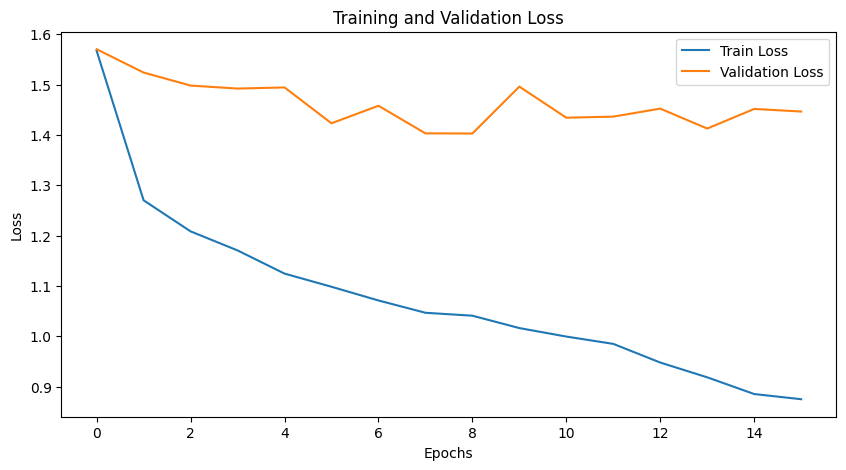

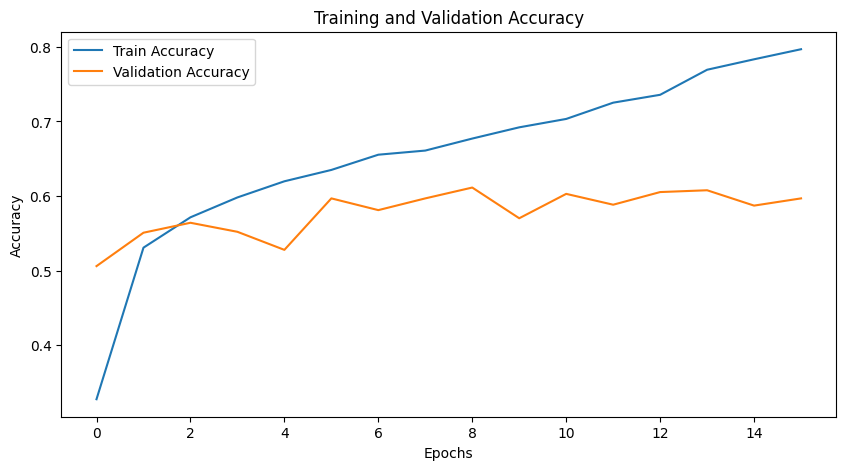

Final Test Loss: 1.3747
Final Test Accuracy: 0.6117
Validation Results
Accuracy: 0.5968523002421308
Precision: 0.6364055390268731
Recall: 0.6426778887655691
F1 Score: 0.636107700614419
Confusion Matrix:
 [[205  94  26   3   0]
 [ 61  63  23   6   0]
 [ 25  46 129  11   1]
 [  1   5  22  72   6]
 [  0   0   0   3  24]]
Test Results
Accuracy: 0.6117149758454107
Precision: 0.6423236590893188
Recall: 0.6510203646106595
F1 Score: 0.643741816244987
Confusion Matrix:
 [[423 157  55   2   2]
 [104 123  65   4   0]
 [ 44 110 259  31   3]
 [  1   7  42 164   9]
 [  0   0   0   7  44]]


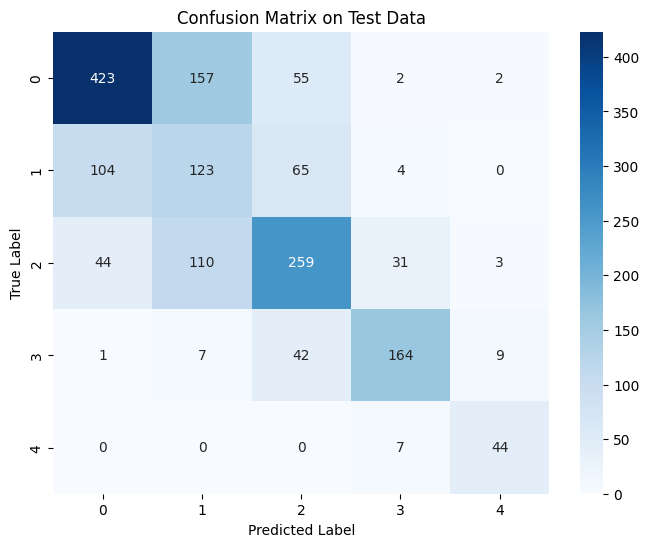

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.07)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3)

num_epochs = 25
patience = 8
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
f1_score_list = []

best_val_loss = np.inf
epochs_no_improve = 0
best_f1 = 0

for epoch in range(num_epochs):
  # Training mode
  model.train()
  running_loss = 0
  correct_train = 0
  total_train = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Compute training accuracy
    _, preds = torch.max(outputs, 1)
    correct_train += (preds == labels).sum().item()
    total_train += labels.size(0)

  train_loss = running_loss / len(train_loader)
  train_accuracy = correct_train / total_train

  train_loss_list.append(train_loss)
  train_acc_list.append(train_accuracy)

  # Evaluation mode
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  all_labels = []
  all_preds = []

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())

  val_loss = val_loss / len(val_loader)
  val_accuracy = correct / total
  val_f1 = f1_score(all_labels, all_preds, average='macro')

  val_loss_list.append(val_loss)
  val_acc_list.append(val_accuracy)
  f1_score_list.append(val_f1)

  scheduler.step(val_loss)

  if val_f1 > best_f1:
    best_f1 = val_f1
    epochs_no_improve = 0
    print("New best model")
    torch.save(model.state_dict(), 'best_model2.pt')
  else:
    epochs_no_improve += 1
    print(f"EarlyStopping counter: {epochs_no_improve} out of {patience}")
    if epochs_no_improve >= patience:
      print(f"Early stopping triggered after {epoch+1} epochs.")
      break

  print(f"Epoch {epoch+1}/{num_epochs} | "
    f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
    f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
    f"F1 Score: {val_f1:.4f} | Best F1: {best_f1:.4f}")

model.load_state_dict(torch.load('best_model2.pt', map_location=device))


# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(model, val_loader, device)

print("Validation Results")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print("Confusion Matrix:\n", val_cm)

test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)

print("Test Results")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print("Confusion Matrix:\n", test_cm)

plt.figure(figsize=(8,6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()

# CNN Model 3

New best model
Epoch 1/25 | Train Loss: 1.5190 | Train Acc: 0.3693 | Val Loss: 1.5547 | Val Acc: 0.4685 | F1 Score: 0.4729 | Best F1: 0.4729
New best model
Epoch 2/25 | Train Loss: 1.2576 | Train Acc: 0.5471 | Val Loss: 1.4584 | Val Acc: 0.5521 | F1 Score: 0.5631 | Best F1: 0.5631
New best model
Epoch 3/25 | Train Loss: 1.1840 | Train Acc: 0.5855 | Val Loss: 1.4209 | Val Acc: 0.5666 | F1 Score: 0.6094 | Best F1: 0.6094
EarlyStopping counter: 1 out of 8
Epoch 4/25 | Train Loss: 1.1349 | Train Acc: 0.6028 | Val Loss: 1.4155 | Val Acc: 0.5944 | F1 Score: 0.5921 | Best F1: 0.6094
New best model
Epoch 5/25 | Train Loss: 1.1144 | Train Acc: 0.6329 | Val Loss: 1.3836 | Val Acc: 0.5920 | F1 Score: 0.6267 | Best F1: 0.6267
New best model
Epoch 6/25 | Train Loss: 1.0708 | Train Acc: 0.6438 | Val Loss: 1.4143 | Val Acc: 0.5835 | F1 Score: 0.6396 | Best F1: 0.6396
EarlyStopping counter: 1 out of 8
Epoch 7/25 | Train Loss: 1.0529 | Train Acc: 0.6644 | Val Loss: 1.4043 | Val Acc: 0.5872 | F1 Score: 

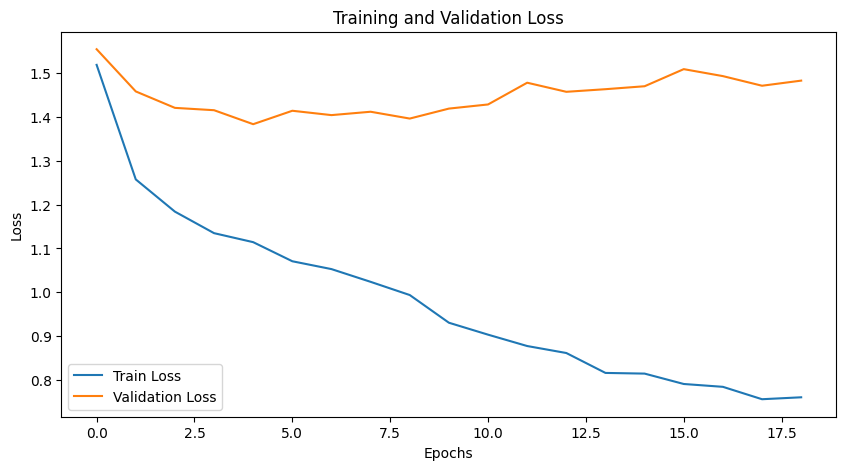

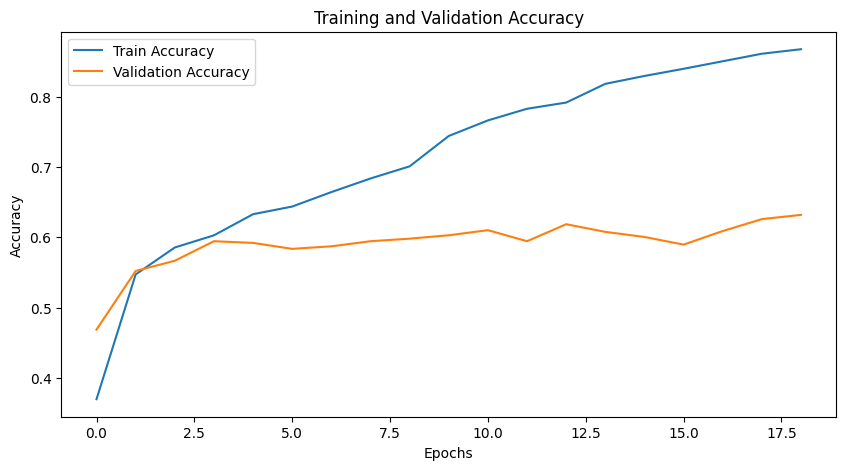

Final Test Loss: 1.3844
Final Test Accuracy: 0.6395
Validation Results
Accuracy: 0.6101694915254238
Precision: 0.6666808258830474
Recall: 0.6535568479066219
F1 Score: 0.6547467398489276
Confusion Matrix:
 [[217  89  21   1   0]
 [ 51  75  23   4   0]
 [ 23  65 110  14   0]
 [  3   4  16  79   4]
 [  0   0   0   4  23]]
Test Results
Accuracy: 0.6394927536231884
Precision: 0.6847625192527153
Recall: 0.6863013143648609
F1 Score: 0.6780762187475212
Confusion Matrix:
 [[453 165  21   0   0]
 [ 95 151  48   2   0]
 [ 51 125 233  38   0]
 [  1  14  22 176  10]
 [  0   0   0   5  46]]


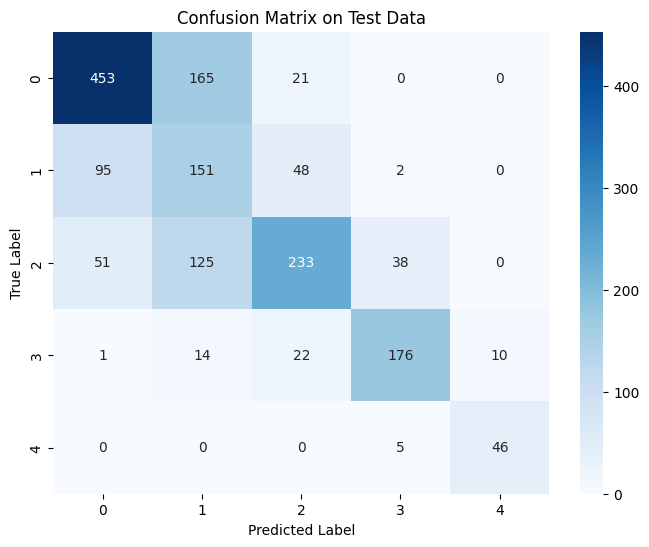

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.07)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003,
                              weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3)

num_epochs = 25
patience = 8
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
f1_score_list = []

best_val_loss = np.inf
epochs_no_improve = 0
best_f1 = 0

for epoch in range(num_epochs):
  # Training mode
  model.train()
  running_loss = 0
  correct_train = 0
  total_train = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Compute training accuracy
    _, preds = torch.max(outputs, 1)
    correct_train += (preds == labels).sum().item()
    total_train += labels.size(0)

  train_loss = running_loss / len(train_loader)
  train_accuracy = correct_train / total_train

  train_loss_list.append(train_loss)
  train_acc_list.append(train_accuracy)

  # Evaluation mode
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  all_labels = []
  all_preds = []

  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())

  val_loss = val_loss / len(val_loader)
  val_accuracy = correct / total
  val_f1 = f1_score(all_labels, all_preds, average='macro')

  val_loss_list.append(val_loss)
  val_acc_list.append(val_accuracy)
  f1_score_list.append(val_f1)

  scheduler.step(val_loss)

  # if val_loss < best_val_loss:
  #   best_val_loss = val_loss
  if val_f1 > best_f1:
    best_f1 = val_f1
    epochs_no_improve = 0
    print("New best model")
    torch.save(model.state_dict(), 'best_model3.pt')
  else:
    epochs_no_improve += 1
    print(f"EarlyStopping counter: {epochs_no_improve} out of {patience}")
    if epochs_no_improve >= patience:
      print(f"Early stopping triggered after {epoch+1} epochs.")
      break

  print(f"Epoch {epoch+1}/{num_epochs} | "
    f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
    f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
    f"F1 Score: {val_f1:.4f} | Best F1: {best_f1:.4f}")

model.load_state_dict(torch.load('best_model3.pt', map_location=device))


# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    _, preds = torch.max(outputs, 1)
    correct += (preds == labels).sum().item()
    total += labels.size(0)

test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(model, val_loader, device)

print("Validation Results")
print("Accuracy:", val_accuracy)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("F1 Score:", val_f1)
print("Confusion Matrix:\n", val_cm)

test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)

print("Test Results")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print("Confusion Matrix:\n", test_cm)

plt.figure(figsize=(8,6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Data")
plt.show()

# Knee X-ray Analysis with ResNet for Osteoarthritis
From: https://www.kaggle.com/code/bernardadhitya/knee-x-ray-analysis-with-resnet-for-osteoarthritis

This is available code from a kaggle user. It is a quick demonstration on how to use a Convolutional Neural Network (CNN), specifically a pre-trained ResNet model, to analyze knee X-ray images and assess the severity of osteoarthritis. As such, the model does not perform to the best of CNNs abilities.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashwatwork/knee-osteoarthritis-dataset-with-severity")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'knee-osteoarthritis-dataset-with-severity' dataset.
Path to dataset files: /kaggle/input/knee-osteoarthritis-dataset-with-severity


In [ ]:
def load_dataset_as_dataframe(path, subdir):
    # Define the path to the dataset
    data_dir = f'{path}/{subdir}'
    print(f'Load dataset from `{subdir}` subdirectory')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

In [ ]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe(path, 'train')
test_df = load_dataset_as_dataframe(path, 'test')


Load dataset from `train` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}

Load dataset from `test` subdirectory
Classes: ['0', '1', '2', '3', '4']
{0: 639, 1: 296, 2: 447, 3: 223, 4: 51}



In [ ]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


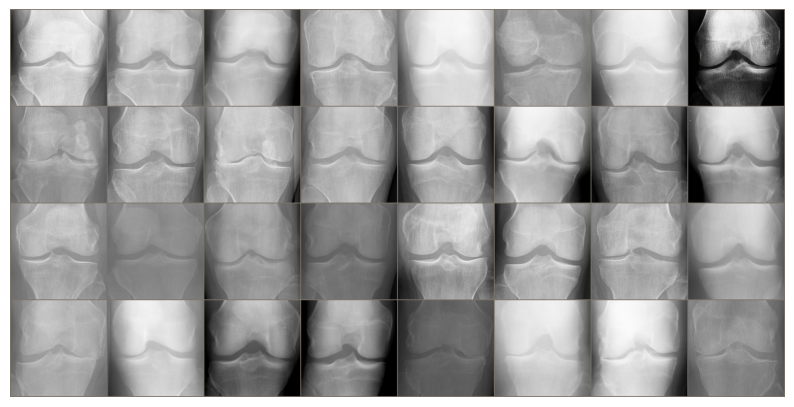

In [ ]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.5MB/s]


In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Number of epochs
num_epochs = 25

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch [1/25]: 100%|██████████| 181/181 [00:42<00:00,  4.27it/s, loss=1.3617, acc=49.48%]


Epoch [1/25], Loss: 1.2060, Accuracy: 0.4948


Epoch [2/25]: 100%|██████████| 181/181 [00:20<00:00,  8.73it/s, loss=1.0040, acc=57.62%]


Epoch [2/25], Loss: 1.0046, Accuracy: 0.5762


Epoch [3/25]: 100%|██████████| 181/181 [00:20<00:00,  8.84it/s, loss=0.7976, acc=60.66%]


Epoch [3/25], Loss: 0.9243, Accuracy: 0.6066


Epoch [4/25]: 100%|██████████| 181/181 [00:21<00:00,  8.57it/s, loss=1.0691, acc=61.89%]


Epoch [4/25], Loss: 0.9019, Accuracy: 0.6189


Epoch [5/25]: 100%|██████████| 181/181 [00:20<00:00,  8.71it/s, loss=0.8820, acc=64.71%]


Epoch [5/25], Loss: 0.8400, Accuracy: 0.6471


Epoch [6/25]: 100%|██████████| 181/181 [00:22<00:00,  7.98it/s, loss=0.6881, acc=65.02%]


Epoch [6/25], Loss: 0.8106, Accuracy: 0.6502


Epoch [7/25]: 100%|██████████| 181/181 [00:21<00:00,  8.62it/s, loss=0.7604, acc=67.06%]


Epoch [7/25], Loss: 0.7790, Accuracy: 0.6706


Epoch [8/25]: 100%|██████████| 181/181 [00:21<00:00,  8.61it/s, loss=1.0932, acc=67.67%]


Epoch [8/25], Loss: 0.7546, Accuracy: 0.6767


Epoch [9/25]: 100%|██████████| 181/181 [00:21<00:00,  8.60it/s, loss=0.6675, acc=69.57%]


Epoch [9/25], Loss: 0.7245, Accuracy: 0.6957


Epoch [10/25]: 100%|██████████| 181/181 [00:20<00:00,  8.62it/s, loss=0.3398, acc=72.15%]


Epoch [10/25], Loss: 0.6754, Accuracy: 0.7215


Epoch [11/25]: 100%|██████████| 181/181 [00:23<00:00,  7.69it/s, loss=1.2171, acc=73.19%]


Epoch [11/25], Loss: 0.6373, Accuracy: 0.7319


Epoch [12/25]: 100%|██████████| 181/181 [00:20<00:00,  8.83it/s, loss=1.0045, acc=74.45%]


Epoch [12/25], Loss: 0.6153, Accuracy: 0.7445


Epoch [13/25]: 100%|██████████| 181/181 [00:20<00:00,  8.73it/s, loss=0.4116, acc=75.96%]


Epoch [13/25], Loss: 0.5770, Accuracy: 0.7596


Epoch [14/25]: 100%|██████████| 181/181 [00:20<00:00,  8.74it/s, loss=0.5434, acc=77.90%]


Epoch [14/25], Loss: 0.5209, Accuracy: 0.7790


Epoch [15/25]: 100%|██████████| 181/181 [00:20<00:00,  8.90it/s, loss=0.7947, acc=80.72%]


Epoch [15/25], Loss: 0.4765, Accuracy: 0.8072


Epoch [16/25]: 100%|██████████| 181/181 [00:20<00:00,  8.63it/s, loss=0.4050, acc=81.83%]


Epoch [16/25], Loss: 0.4532, Accuracy: 0.8183


Epoch [17/25]: 100%|██████████| 181/181 [00:21<00:00,  8.59it/s, loss=0.6220, acc=83.90%]


Epoch [17/25], Loss: 0.3923, Accuracy: 0.8390


Epoch [18/25]: 100%|██████████| 181/181 [00:20<00:00,  8.89it/s, loss=0.3067, acc=84.80%]


Epoch [18/25], Loss: 0.3790, Accuracy: 0.8480


Epoch [19/25]: 100%|██████████| 181/181 [00:21<00:00,  8.58it/s, loss=0.4400, acc=87.35%]


Epoch [19/25], Loss: 0.3303, Accuracy: 0.8735


Epoch [20/25]: 100%|██████████| 181/181 [00:20<00:00,  8.77it/s, loss=0.3308, acc=89.88%]


Epoch [20/25], Loss: 0.2726, Accuracy: 0.8988


Epoch [21/25]: 100%|██████████| 181/181 [00:20<00:00,  8.65it/s, loss=0.2217, acc=90.79%]


Epoch [21/25], Loss: 0.2444, Accuracy: 0.9079


Epoch [22/25]: 100%|██████████| 181/181 [00:20<00:00,  8.68it/s, loss=0.1573, acc=91.83%]


Epoch [22/25], Loss: 0.2165, Accuracy: 0.9183


Epoch [23/25]: 100%|██████████| 181/181 [00:20<00:00,  8.87it/s, loss=0.2576, acc=93.08%]


Epoch [23/25], Loss: 0.1857, Accuracy: 0.9308


Epoch [24/25]: 100%|██████████| 181/181 [00:21<00:00,  8.57it/s, loss=0.1972, acc=93.27%]


Epoch [24/25], Loss: 0.1765, Accuracy: 0.9327


Epoch [25/25]: 100%|██████████| 181/181 [00:21<00:00,  8.44it/s, loss=0.4147, acc=95.26%]

Epoch [25/25], Loss: 0.1320, Accuracy: 0.9526


Accuracy on test set: 0.6057
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.67       639
           1       0.30      0.34      0.32       296
           2       0.58      0.71      0.64       447
           3       0.80      0.70      0.75       223
           4       0.79      0.73      0.76        51

    accuracy                           0.61      1656
   macro avg       0.64      0.62      0.63      1656
weighted avg       0.63      0.61      0.61      1656

Confusion Matrix:
[[393 163  81   2   0]
 [ 95 100  98   3   0]
 [ 39  70 317  21   0]
 [  5   5  47 156  10]
 [  0   0   1  13  37]]


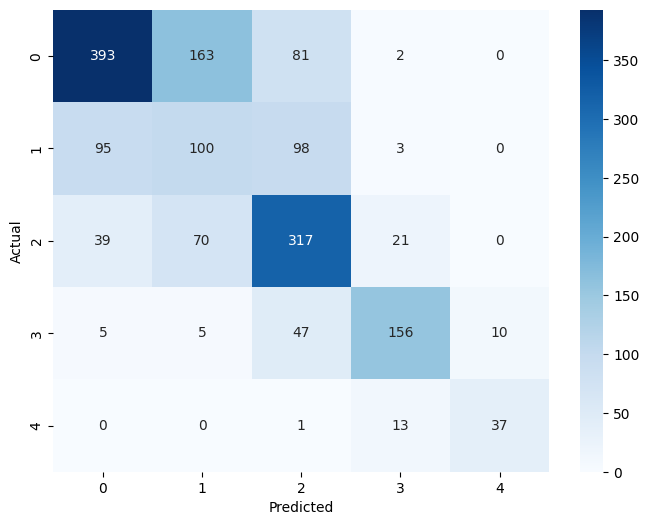

In [ ]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
